# Mixscape - analysis of single-cell pooled CRSIPR screen

Guide RNAs can sometimes lead to off-target effects or exhibit variable efficacy in genome editing, underscoring the necessity for computational quality control to predict and enhance their specificity and performance.
Mixscape classifies targeted cells based on their response to a perturbation into perturbed and not perturbed {cite}`Papalexi2021`.
To do so, mixscape analyzes each cell's "perturbation signature" and then categorizes the cell into either a 'perturbed' or 'escaping' subclass.

This vignette reproduces the [mixscape vignette](https://satijalab.org/seurat/articles/mixscape_vignette.html).

In particular, we show how to use mixscape for the analyses of single-cell pooled CRISPR screens by:

1. Calculating the perturbation-specific signature of every cell.
2. Identifying and removing cells that have ‘escaped’ CRISPR perturbation.
3. Visualizing similarities/differences across different perturbations.

```{dropdown} Applying mixscape to CRISPRa and CRISPRi data

For CRISPRi and CRISPRa, applying Mixscape is more nuanced but still valid under certain conditions.
Unlike knockouts, these modalities do not introduce permanent genomic alterations, but variability in perturbation efficiency can create functionally unperturbed cells.
Factors such as incomplete transcriptional repression/activation, guide RNA efficiency, chromatin state, or variable effector recruitment (e.g., KRAB for CRISPRi, VP64 for CRISPRa) can lead to heterogeneous and continuous perturbation effects.
If these effects result in a clear separation between perturbed and unperturbed-like transcriptomic states, Mixscape can still be meaningfully applied.
However, careful validation is needed to ensure that the identified unperturbed population reflects true biological variability rather than technical artifacts.
```

## Setup

In [1]:
import muon as mu
import pertpy as pt
import scanpy as sc

## Dataset

We use the Papalexi ECCITE-seq 111 gRNA ECCITE-seq dataset which was generated from stimulated THP-1 cells.

In [2]:
mdata = pt.dt.papalexi_2021()
mdata

MuData object with n_obs × n_vars = 20729 × 18776
  var:	'name'
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    hto:	20729 x 12
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    gdo:	20729 x 111
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'

## Preprocessing

We preprocess both RNA and proteins according to the standard pipelines.

### RNA

In [3]:
mdata["rna"]

AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

In [4]:
sc.pp.normalize_total(mdata["rna"])

In [5]:
sc.pp.log1p(mdata["rna"])

In [6]:
sc.pp.highly_variable_genes(mdata["rna"], subset=True)

### Protein

In [7]:
mdata["adt"]

AnnData object with n_obs × n_vars = 20729 × 4
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

In [8]:
# Normalize across cells (axis=1)
mu.prot.pp.clr(mdata["adt"], axis=1)

/home/lukas/miniforge3/envs/pertpy/lib/python3.12/site-packages/muon/_prot/preproc.py:222: UserWarning: adata.X is sparse but not in CSR format. Converting to CSR.
  warn("adata.X is sparse but not in CSR format. Converting to CSR.")


## RNA-based clustering is driven by confounding sources of variation

Using the common gene expression-based cell clustering workflow, we expect to discern clusters unique to specific perturbations.
Contrary to this, clustering is mainly influenced by cell cycle phases and replicate IDs.
The exception is a single cluster, characterized by cells expressing gRNAs related to the IFNgamma pathway.

```{dropdown} Assumptions when calculating perturbation signatures

When calculating the perturbation-specific signatures, mixscape makes strong assumptions such as cells with a perturbation not exhibiting compositional differences with respect to variation seen within the control cells. Additional limitations include the assumption that perturbation effects are additive and separable from underlying cell state, the equal weighting of all genes regardless of their relevance to the perturbation target, and the failure to account for temporal dynamics in cellular responses where early and late responding genes create composite signatures.
```

In [9]:
sc.pp.pca(mdata["rna"])

In [10]:
sc.pp.neighbors(mdata["rna"], metric="cosine")

In [11]:
sc.tl.umap(mdata["rna"])

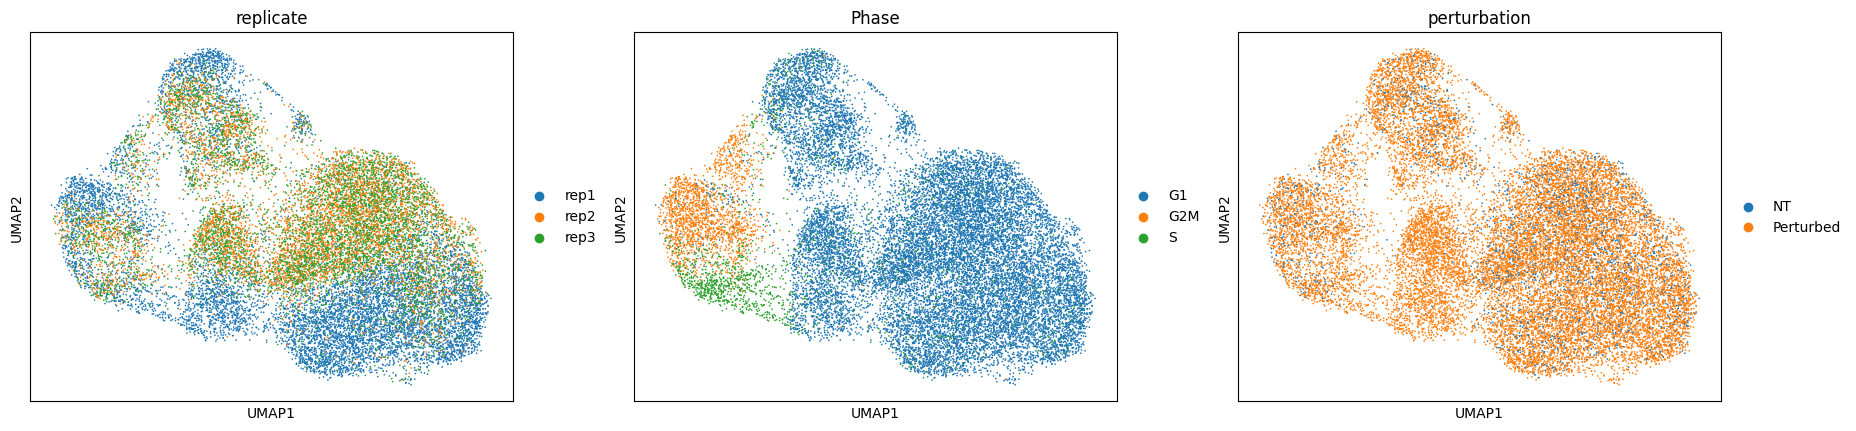

In [12]:
sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])

## Calculating local perturbation signatures mitigates confounding effects

To regress out the confounding effects, we calculate local perturbation signatures.
For each cell, we identify `n_neighbors` cells from the control pool with the most similar mRNA expression profiles.
The perturbation signature is calculated by subtracting the averaged mRNA expression profile of the control neighbors from the mRNA expression profile of each cell.

In [13]:
ms = pt.tl.Mixscape()
ms.perturbation_signature(mdata["rna"], pert_key="perturbation", control="NT", split_by="replicate")

In [14]:
adata_pert = mdata["rna"].copy()

In [15]:
adata_pert.X = adata_pert.layers["X_pert"]

In [16]:
sc.pp.pca(adata_pert)

In [17]:
sc.pp.neighbors(adata_pert, metric="cosine")

In [18]:
sc.tl.umap(adata_pert)

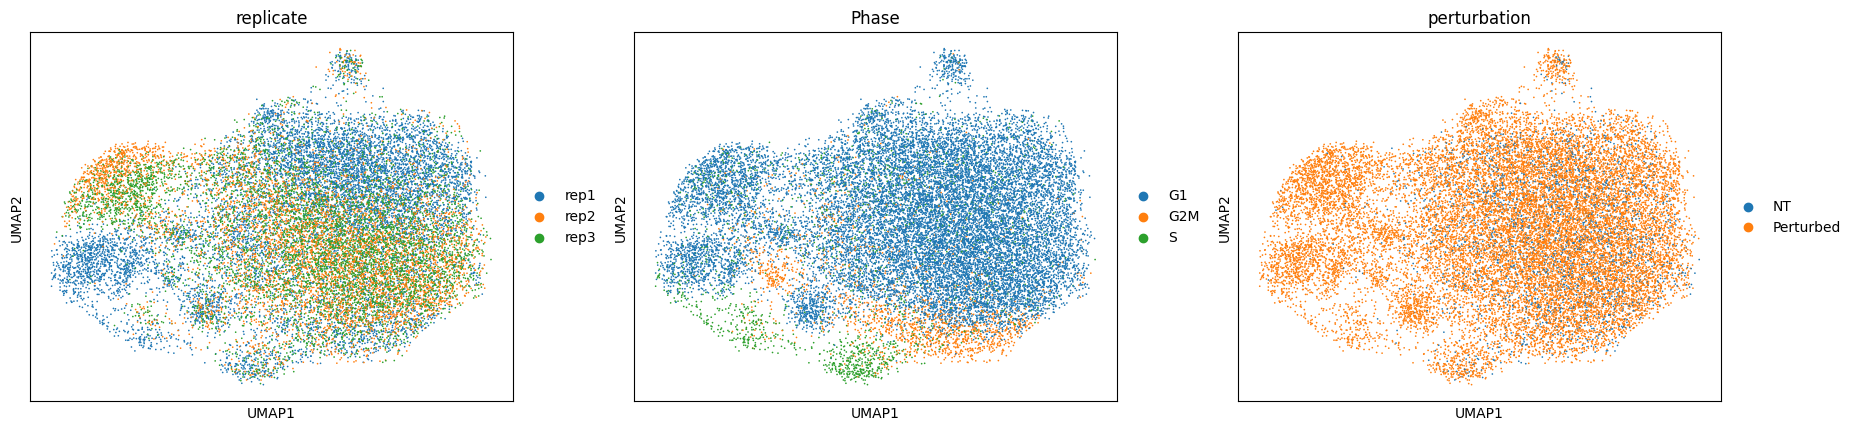

In [19]:
sc.pl.umap(adata_pert, color=["replicate", "Phase", "perturbation"])

## Mixscape identifies cells with no detectable perturbation

mixscape models each target gene class as a combination of two Gaussian distributions: one for knockout (KO) cells and another for non-perturbed (NP) cells.
We assume that NP cells exhibit the same distribution as cells with non-targeting gRNAs (NT).
We estimate the KO cell distribution and then compute the posterior probability of a cell belonging to the KO group.
Cells with a probability above 0.5 are classified as KOs.
This method helped us identify KOs in 11 target gene classes, revealing variations in gRNA targeting efficiency across these classes.

In [20]:
ms.mixscape(adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert")

We detect variation in gRNA targeting efficiency within each class.

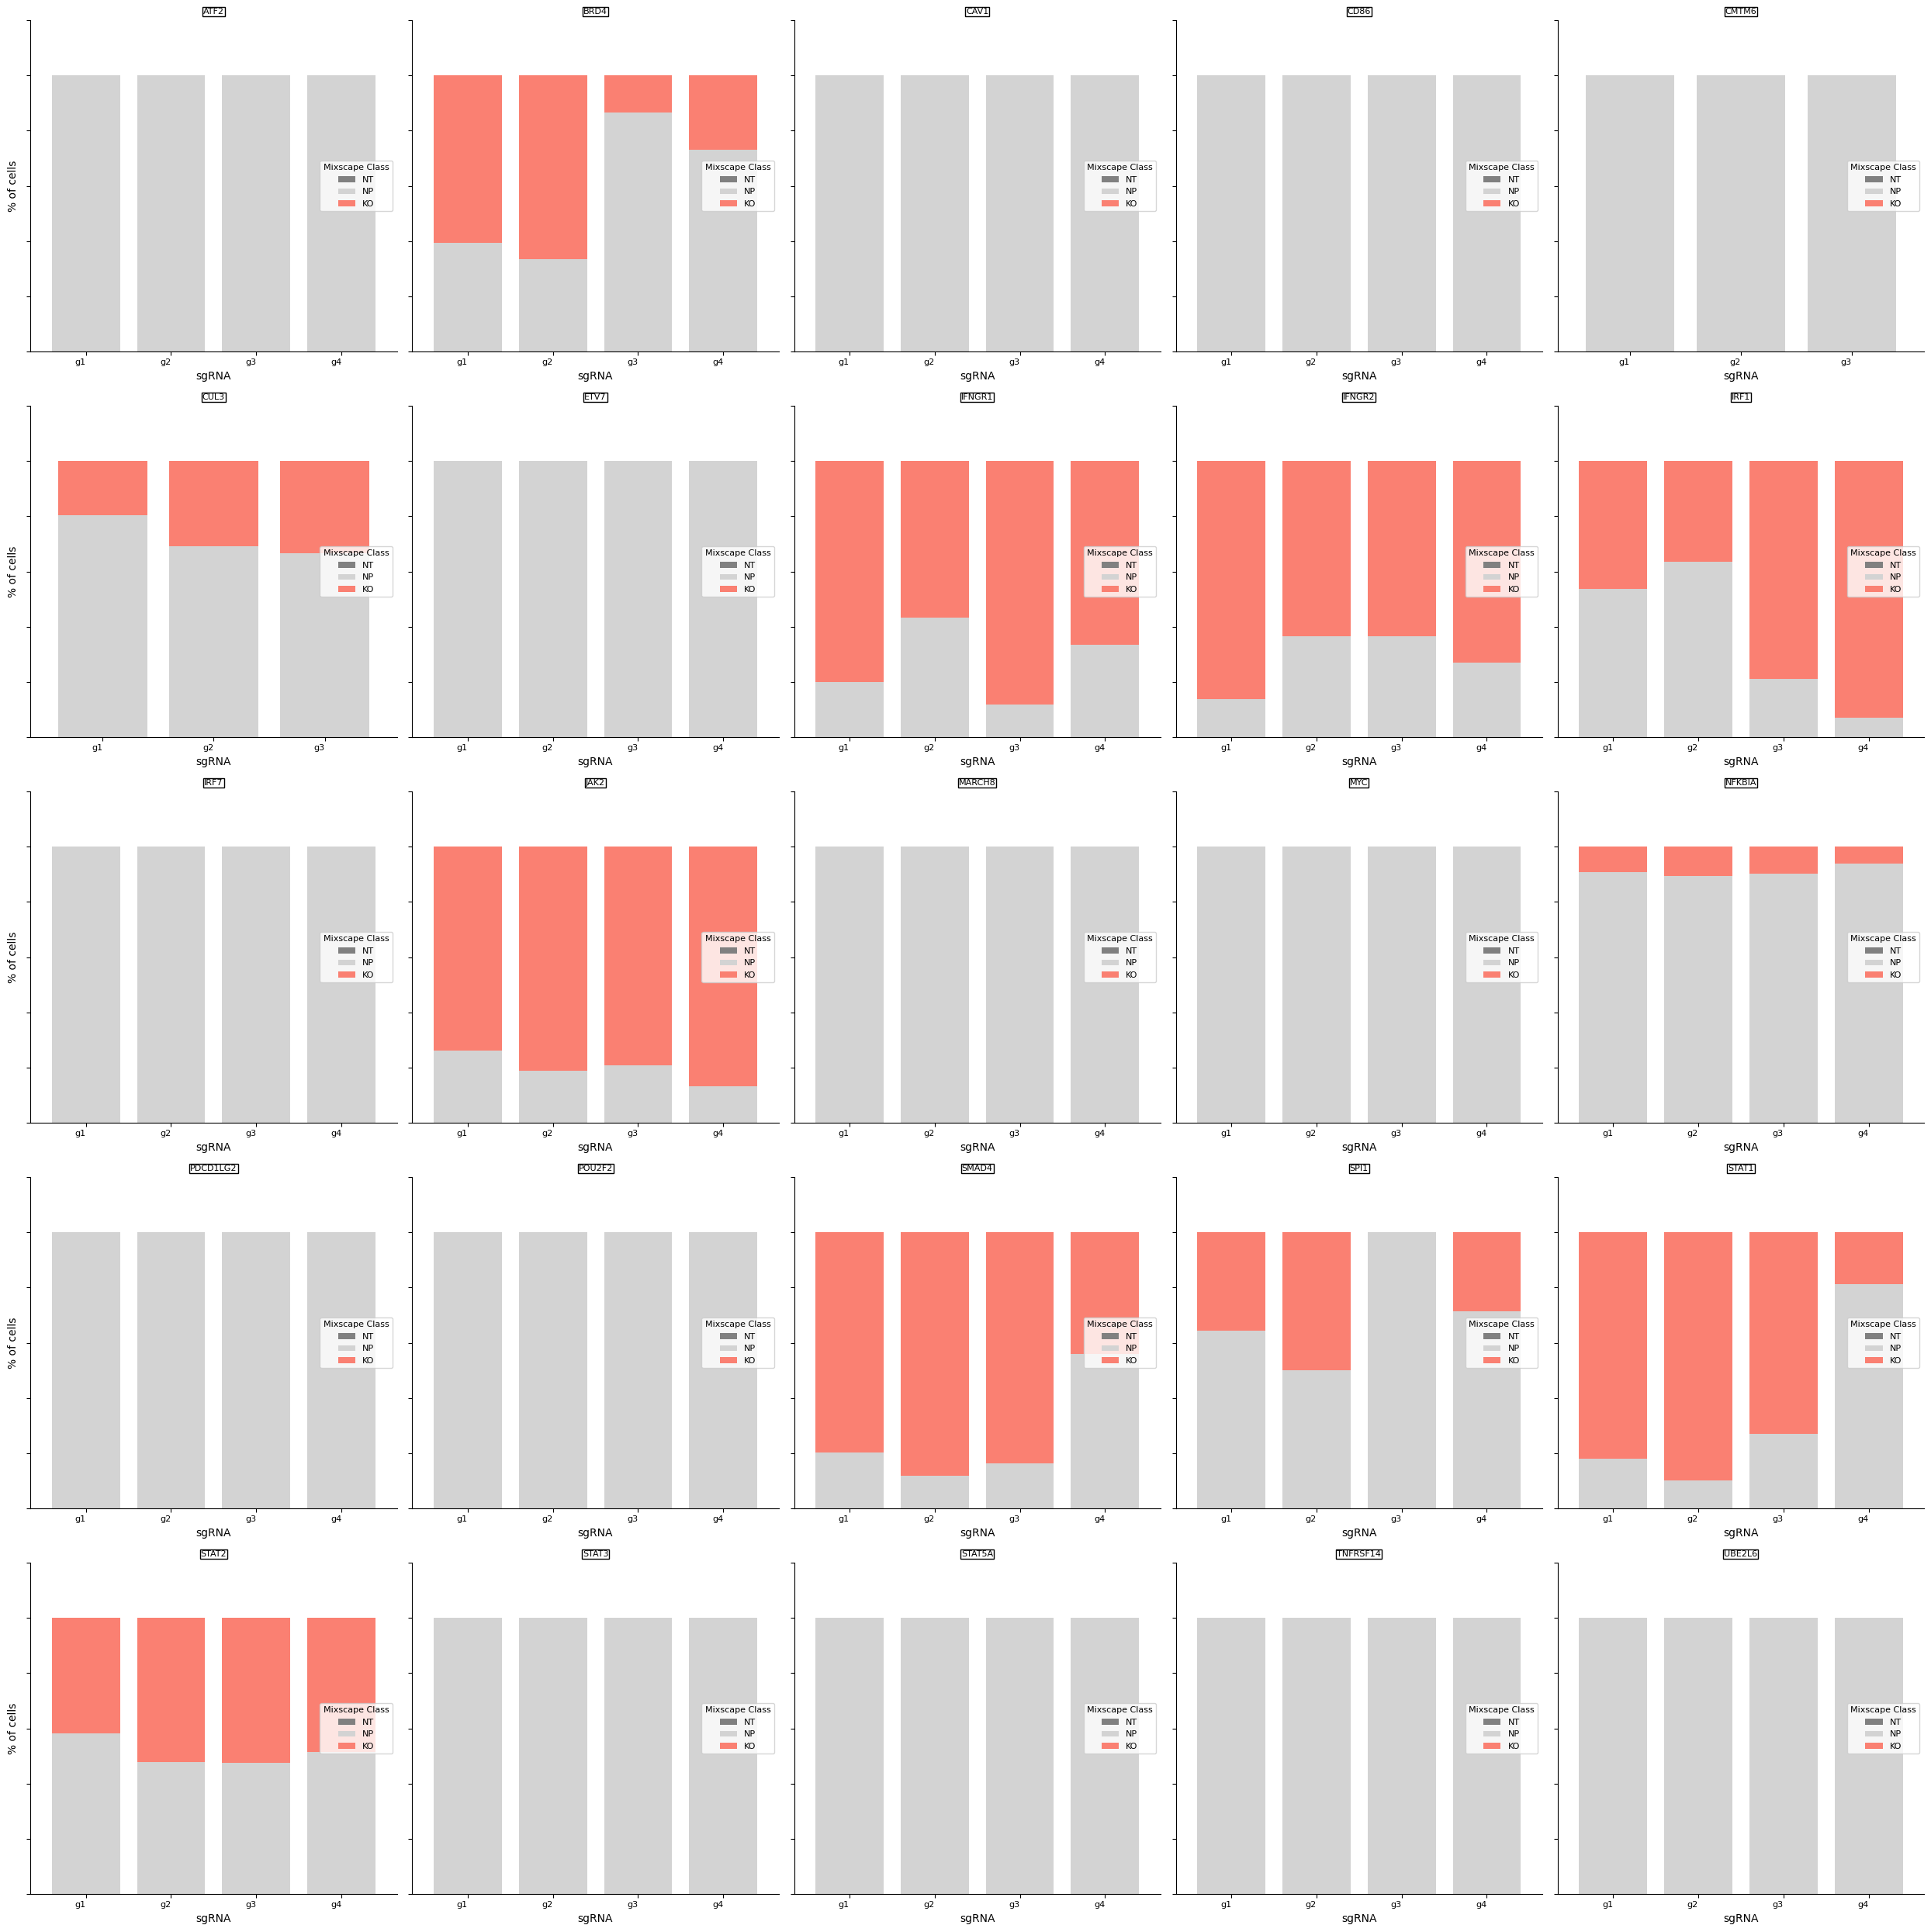

In [21]:
ms.plot_barplot(mdata["rna"], guide_rna_column="NT")

## Inspecting mixscape results

To validate that mixscape accurately assigns perturbation status, we can examine the perturbation score distributions and the posterior probabilities of cells in a specific target gene class, like IFNGR2, comparing these with non-targeting (NT) cells.
Additionally, we can conduct differential expression (DE) analyses, demonstrating that reduced expression of IFNG-pathway genes is unique to IFNGR2 KO cells.
As an independent verification, we can also assess the PD-L1 protein expression levels in non-perturbed (NP) and knockout (KO) cells for genes known to regulate PD-L1.


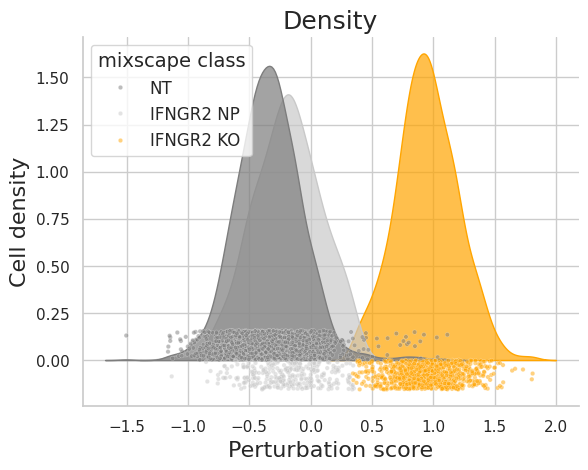

In [22]:
ms.plot_perturbscore(adata=mdata["rna"], labels="gene_target", target_gene="IFNGR2", color="orange")

Inspect the posterior probability values in NP and KO cells.

/home/lukas/miniforge3/envs/pertpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/lukas/miniforge3/envs/pertpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


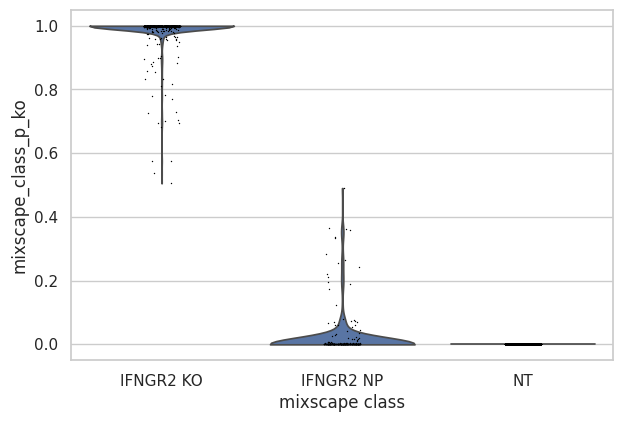

In [23]:
ms.plot_violin(
    adata=mdata["rna"],
    target_gene_idents=["NT", "IFNGR2 NP", "IFNGR2 KO"],
    groupby="mixscape_class",
)

Run DE analysis and visualize results on a heatmap ordering cells by their posterior probability values.

categories: IFNGR2 KO, IFNGR2 NP, NT
var_group_labels: NT


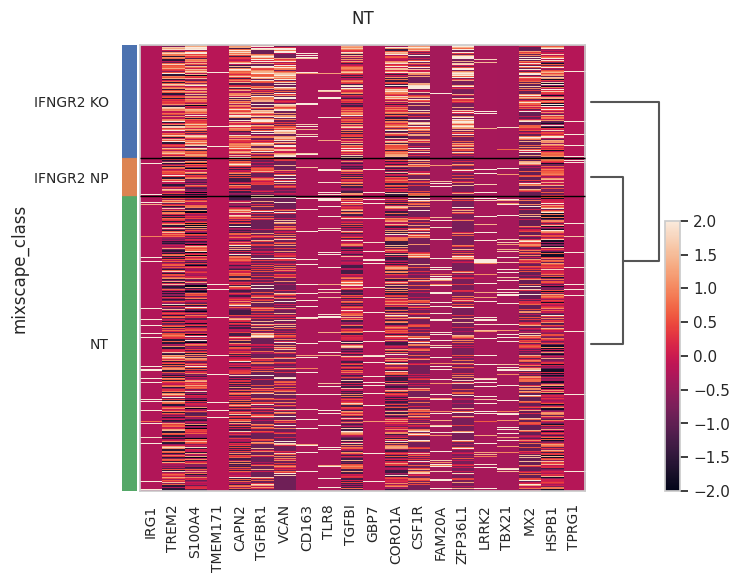

In [24]:
ms.plot_heatmap(
    adata=mdata["rna"],
    labels="gene_target",
    target_gene="IFNGR2",
    layer="X_pert",
    control="NT",
)

Show that only IFNG pathway KO cells have a reduction in PD-L1 protein expression.

/home/lukas/miniforge3/envs/pertpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


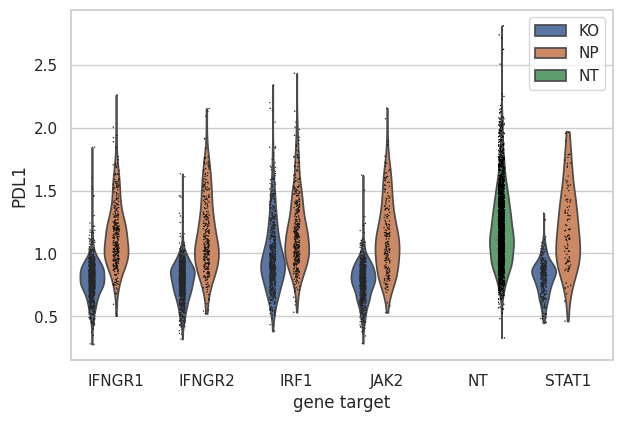

In [25]:
mdata["adt"].obs["mixscape_class_global"] = mdata["rna"].obs["mixscape_class_global"]
ms.plot_violin(
    adata=mdata["adt"],
    target_gene_idents=["NT", "JAK2", "STAT1", "IFNGR1", "IFNGR2", "IRF1"],
    keys="PDL1",
    groupby="gene_target",
    hue="mixscape_class_global",
)

## Visualizing perturbation responses with Linear Discriminant Analysis (LDA)

Finally, we use LDA as a dimensionality reduction method to visualize perturbation-specific clusters.
LDA tries to maximize the separability of known labels (mixscape classes) using both gene expression and the labels as input.

In [26]:
ms = pt.tl.Mixscape()
ms.lda(adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert")

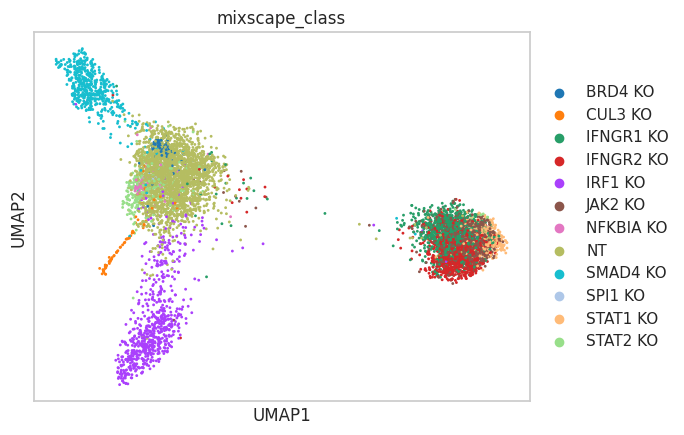

In [27]:
ms.plot_lda(adata=mdata["rna"], control="NT")